# The CosmoClassifier
In this project, I have used the Data Release 18 version of Sloan Digital Sky Survey (SDSS) dataset to train a classifier algorithm to predict whether the given credentials corresponds to a Galaxy(class 0), Star(class 1) or Quasar(class 2). This notebook is used as a playground to test different hyperparameter settings as well as preprocessing approaches. 

We will 4 different classifier algorithms to test the results and select the one which offers the best result. These are:
1. Random Forest **(This File)**
2. Logistic Regression
3. Suppor Vector Classifier (with RBF kerel)

The models are implemented in separate `.ipynb` files to avoid confusion in one notebook. You can find them all in the `notebooks` subdirectory.
   
We will also use 3 different dimensionality reduction techniques, which include:
1. Sequential Feature Selection (SFS)
2. Linear Discriminant Analysis (LDA)
3. Principle Component Analysis (PCA)

Importing the libraries

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score,KFold,train_test_split,learning_curve,validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Basic Preprocessing

Importing the dataset

In [ ]:
df_raw = pd.read_csv("Datasets/SDSS_DR18.csv")

Dropping the identifier columns which may lead to data leakage

In [21]:
df_raw = df_raw.drop(columns=["objid", "specobjid", "run", "rerun", "camcol", "field", "plate", "mjd", "fiberid"])

Identifying and mapping the classes

In [22]:
print(df_raw["class"].value_counts())
df_1 = df_raw.copy()

class
GALAXY    52343
STAR      37232
QSO       10425
Name: count, dtype: int64


In [23]:
df_1["class"] = df_1["class"].map({
  "GALAXY":0,
  "STAR":1,
  "QSO":2
})
df_1["class"].head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    0
9    1
Name: class, dtype: int64

Checking for null values

In [24]:
df_1.isna().value_counts()

ra     dec    u      g      r      i      z      petroRad_u  petroRad_g  petroRad_i  petroRad_r  petroRad_z  petroFlux_u  petroFlux_g  petroFlux_i  petroFlux_r  petroFlux_z  petroR50_u  petroR50_g  petroR50_i  petroR50_r  petroR50_z  psfMag_u  psfMag_r  psfMag_g  psfMag_i  psfMag_z  expAB_u  expAB_g  expAB_r  expAB_i  expAB_z  redshift  class
False  False  False  False  False  False  False  False       False       False       False       False       False        False        False        False        False        False       False       False       False       False       False     False     False     False     False     False    False    False    False    False    False     False    100000
Name: count, dtype: int64

No null values were found, so we are going to skip dropping nulls.

Copying the dataset and specifying the target & feature columns

In [37]:
df = df_1.copy()
column_names = df.columns
y = df.iloc[:,-1].to_numpy()      # Target Column
x = df.iloc[:,:-1]    # Feature Column
feature_names = x.columns
x = x.to_numpy()

## ML Preprocessing, Model training, Evaluation 

Performing train-test split

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=2/10,random_state=120,shuffle=True,stratify=y)

### Building Pipeline (SFS)

In [ ]:
rf_model = RandomForestClassifier(
  n_estimators=150,max_depth=10,random_state=102,class_weight="balanced",n_jobs=-1)
sfs = SequentialFeatureSelector(
  rf_model,n_features_to_select="auto",tol=0.007,direction="forward",cv=None)

preprocessor = Pipeline([
  ("imputation",SimpleImputer(strategy="median")),
  ("scale", StandardScaler()),
  ("sfs",sfs)
])
pipe = Pipeline([
  ("preprocessor",preprocessor),
  ("model",rf_model)
])

kfold = KFold(n_splits=3,shuffle=True,random_state=10)
score = cross_val_score(pipe,x,y,cv=kfold)
print(score)
print(f"Average = {score.mean()}")

### Building Pipeline (PCA)

In [63]:
rf_model = RandomForestClassifier(
  n_estimators=150,max_depth=10,random_state=103,class_weight="balanced",n_jobs=-1)
pca = PCA(n_components=20,random_state=19)

preprocessor = Pipeline([
  ("imputation",SimpleImputer(strategy="median")),
  ("scale", StandardScaler()),
  ("pca",pca)
])
pipe = Pipeline([
  ("preprocessor",preprocessor),
  ("model",rf_model)
])

kfold = KFold(n_splits=3,shuffle=True,random_state=10)
score = cross_val_score(pipe,x,y,cv=kfold)
print(score)
print(f"Average = {score.mean()}")

[0.98050039 0.97929979 0.98100981]
Average = 0.980269997696077


#### Calculating **loading** dataframe

In [64]:
pipe.fit(x_train,y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputation', ...), ('scale', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None


In [65]:
after_pca = preprocessor.named_steps["pca"]
comps = after_pca.components_
comps_df = pd.DataFrame(
  comps,index=[f"PC{i+1}" for i in range(after_pca.n_components_)], 
  columns=feature_names
)

exp_vars = after_pca.explained_variance_

def change(x):
  return x * np.sqrt(exp_vars)
loading_df = comps_df.copy()
loading_df = loading_df.apply(change)
loading_df.shape

(20, 33)

#### PCA Loading heatmap

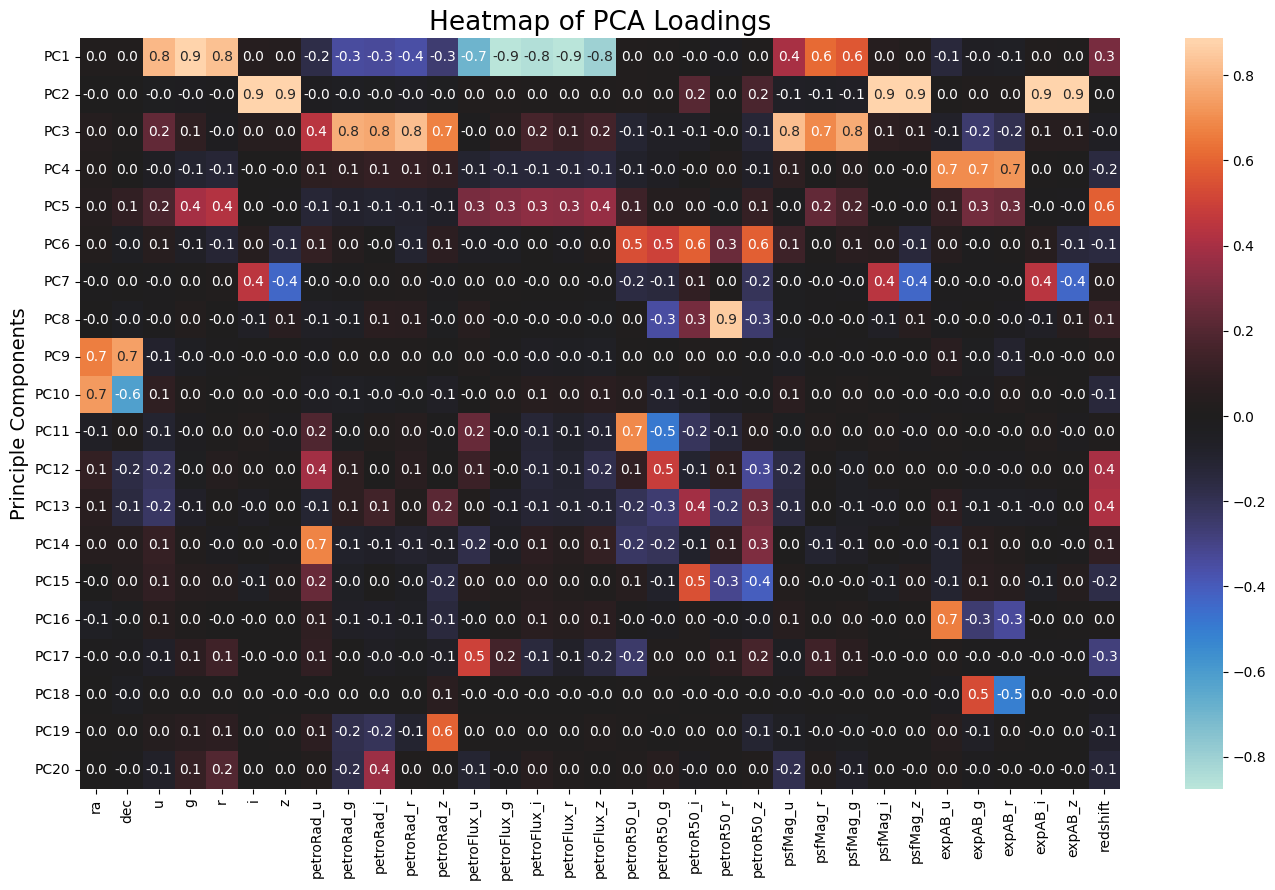

In [66]:
plt.figure(figsize=(14,9))
sns.heatmap(loading_df,cmap="icefire",annot=True,fmt=".1f",center=0)
plt.ylabel("Principle Components",fontdict={"fontsize":14})
plt.title("Heatmap of PCA Loadings",fontdict={"fontsize":19})
plt.tight_layout()
plt.show()

This heatmap visualizes the PCA loadings for 20 Principal Components (PCs) across numerous features. PC1 and PC2 are primarily defined by the spectral bands (g, r, i etc.) and flux values, capturing the bulk of the variance. Loadings quickly drop to near-zero by PC11, indicating that the first 10-12 components are sufficient for dimension reduction and interpretation in this dataset.

#### Learning Curve

Let's plot the **Learning Curve** plot to understand whether the model is fit well or is underfitting/overfitting.

In [67]:
train_size, train_acc, val_acc = learning_curve(
  pipe,x_train,y_train,train_sizes=np.linspace(0.1,1.0,10),
  cv=5,n_jobs=-1,random_state=9,shuffle=True
)

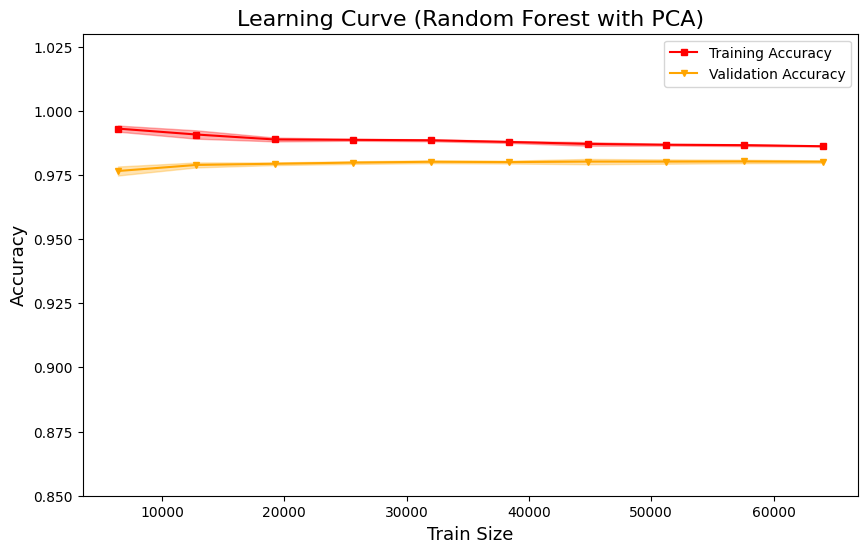

In [68]:
train_mean = np.mean(train_acc, axis=1)
train_std = np.std(train_acc,axis=1)
val_mean = np.mean(val_acc,axis=1)
val_std = np.std(val_acc,axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_size, train_mean, color="red",marker="s",markersize=4,label="Training Accuracy")
plt.fill_between(train_size, train_mean + train_std , train_mean - train_std, color="red",alpha=0.3)

plt.plot(train_size, val_mean, color="orange",marker="v",markersize=4,label="Validation Accuracy")
plt.fill_between(train_size, val_mean + val_std, val_mean - val_std, color="orange",alpha=0.3)

plt.title("Learning Curve (Random Forest with PCA)",fontdict={"fontsize":16})
plt.xlabel("Train Size",fontdict={"fontsize":13})
plt.ylabel("Accuracy",fontdict={"fontsize":13})
plt.ylim(0.85,1.03)
plt.legend()
plt.show()


This learning curve for a Random Forest model after applying PCA shows excellent performance, with both Training Accuracy (red) and Validation Accuracy (orange) consistently high, clustering around 0.98. Crucially, the minimal gap between the two curves indicates that the model exhibits low variance and is not significantly overfitting the data, even at smaller training sizes (around 10,000 samples). The validation accuracy appears to have converged, suggesting that further increases in the training set size are unlikely to yield substantial improvements in generalization performance. 

### Building Pipeline (LDA)

In [69]:
rf_model = RandomForestClassifier(
  n_estimators=150,max_depth=10,random_state=104,class_weight="balanced",n_jobs=-1)
lda = LDA(n_components=2)    
# There are only 2 possible values for n_components since there are only 3 classes.  
# n_estimaors=2 gave the best score. So I kept it for the final version
preprocessor = Pipeline([
  ("imputation",SimpleImputer(strategy="median")),
  ("scale", StandardScaler()),
  ("lda",lda)
])
pipe = Pipeline([
  ("preprocessor",preprocessor),
  ("model",rf_model)
])

kfold = KFold(n_splits=2,shuffle=True,random_state=10)
score = cross_val_score(pipe,x,y,cv=kfold)
print(score)
print(f"Average = {score.mean()}")

[0.9844  0.98478]
Average = 0.9845900000000001


#### Learning Curve

Let's plot the **Learning Curve** plot to understand whether the model is fit well or is underfitting/overfitting.

In [70]:
train_size, train_acc, val_acc = learning_curve(
  pipe,x_train,y_train,train_sizes=np.linspace(0.1,1.0,10),
  cv=5,n_jobs=-1,random_state=9,shuffle=True
)

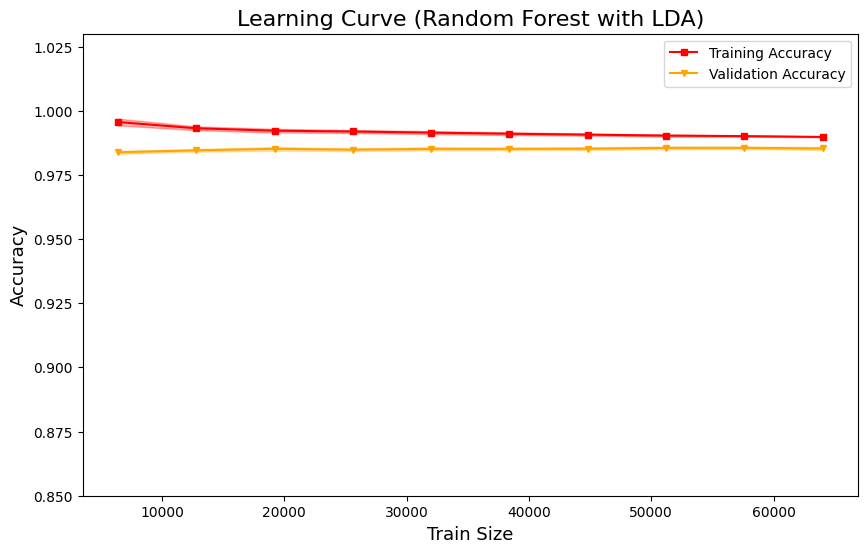

In [71]:
train_mean = np.mean(train_acc, axis=1)
train_std = np.std(train_acc,axis=1)
val_mean = np.mean(val_acc,axis=1)
val_std = np.std(val_acc,axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_size, train_mean, color="red",marker="s",markersize=4,label="Training Accuracy")
plt.fill_between(train_size, train_mean + train_std , train_mean - train_std, color="red",alpha=0.3)

plt.plot(train_size, val_mean, color="orange",marker="v",markersize=4,label="Validation Accuracy")
plt.fill_between(train_size, val_mean + val_std, val_mean - val_std, color="orange",alpha=0.3)

plt.title("Learning Curve (Random Forest with LDA)",fontdict={"fontsize":16})
plt.xlabel("Train Size",fontdict={"fontsize":13})
plt.ylabel("Accuracy",fontdict={"fontsize":13})
plt.ylim(0.85,1.03)
plt.legend()
plt.show()

This learning curve for a Random Forest model using LDA shows that the model achieves near-perfect Training Accuracy (red line) across all sample sizes, hovering just below 1.00. The Validation Accuracy (orange line) is also excellent, remaining stable just under 0.98 as the Train Size increases. The very small gap between the training and validation curves, combined with the high performance, indicates that this model setup (Random Forest with LDA) is both highly accurate and exhibits very low variance/minimal overfitting on the data. 👍

## Summary

Here is a summary of the entire calculation

| Dimensionality Reduction / Models $\downarrow \leftrightarrow$ | Random Forest | Support Vector Classifier | Logistic Regression |
| :--- | :--- | :--- | :--- |
| Principal Component Analysis | 0.9803 | 0.9471 | 0.9725 |
| Linear Discriminant Analysis | 0.9846 | 0.9832 | 0.9832 |
| Sequential Feature Selection | 0.9870 | Null | Null |

From this table, we can see that Random Forest with SFS has achieved the best cross validation score overall. But, we are going to avoid it because of it's extreme complexity and inefficiency. In my Macbook Air M2, it took more than 20 minutes to run even with `n_jobs` set to -1 (all CPU cores are used).

So, we have fixed the Rnadom Forest model with LDA as our final version for the Web App !

**BUT**, There is a catch! Check the `research_2.ipynb` file to know about it.